In [ ]:
%%capture
!pip install azure-storage-blob

!pip install boto3

In [ ]:
%%capture
!pip install tensorflow

!pip install opencv-python

!pip install imutils

!pip install Pillow

!pip install scikit-learn

!pip install matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Data Science/Projects/Banking e-KYC/Codes'

/content/drive/MyDrive/Data Science/Projects/Banking e-KYC/Codes


In [ ]:
%ls

 aws_access.py
 azure_blob_access.py
 complete_image_data_with_labels.csv
 config.py
'Copy of Image_Similary_Modeling.ipynb'
 Data_Exploration.ipynb
 examples/
 face.jpg
 face_recognition.json
 Image_Similarity_Modeling_TransferLearning
 Image_Similary_Modeling.ipynb
 output/
 __pycache__/
 siamese_network.py
 utils.py


## **Siamese Network:**

Video Lecture Link: https://www.coursera.org/lecture/convolutional-neural-networks/siamese-network-bjhmj

**Example - 1:** Identifying if the digits in the two images are same or not.

**---> Conventional CNN image classification**


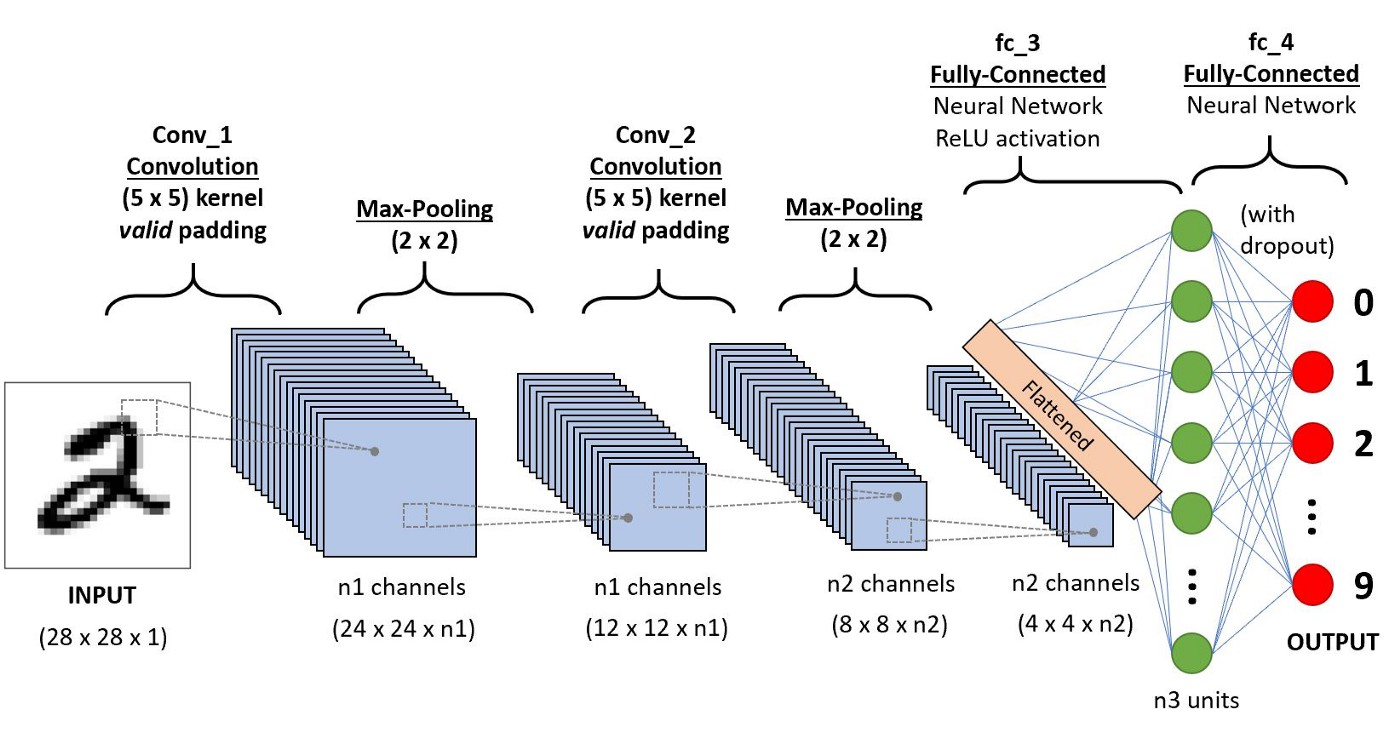

**---> Image Similarity using Siamese network**

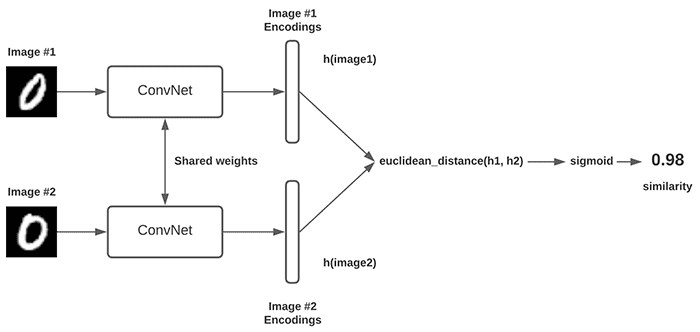

Image #1 encoding ==>  [0.3,0.34,0.9,0.5]

Image #2 encoding ==>  [0.3,0.37,0.92,0.51]

Euclidean Distance ==> encoding_1 - encoding_2 

Sigmoid Activation ==> 0.98 (output will be in 0 to 1 range)

**Example - 2:** Identifying if the persons in the two images are of same gender or not.

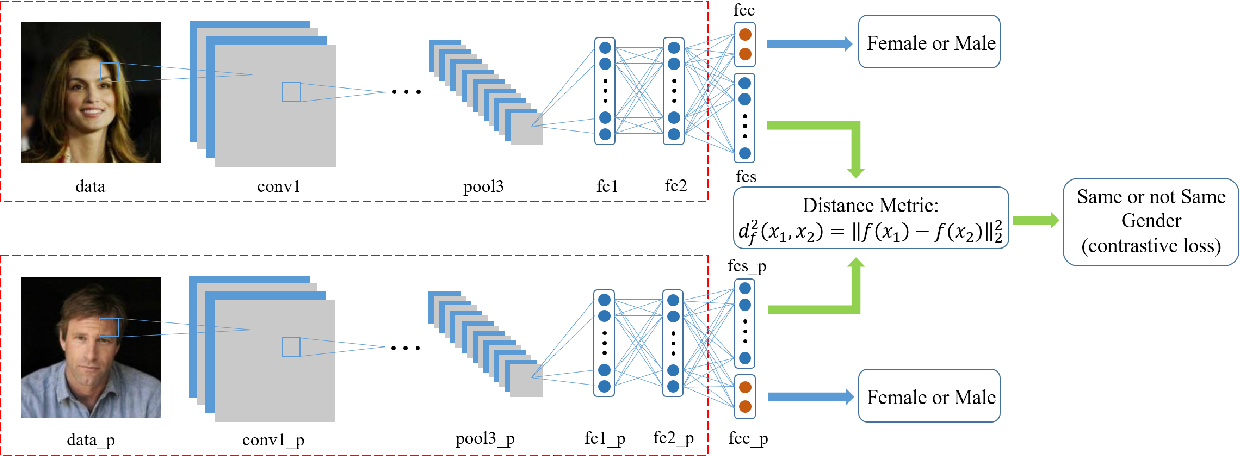

## **Similarity Modeling using Siamese Network:**

In [ ]:
# Importing the necessary libraries
import pandas as pd 
pd.set_option('max_colwidth',None)
from imutils import build_montages
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Loading the image details data
image_data = pd.read_csv('complete_image_data_with_labels.csv')
print(image_data.shape)
image_data.head()

(206, 2)


,s3_img_path,user_id
0,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg,1
1,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg,1
2,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg,10
3,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg,10
4,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg,10


In [ ]:
image_data.head(8)

,s3_img_path,user_id
0,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg,1
1,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg,1
2,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg,10
3,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg,10
4,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg,10
5,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_4.jpg,10
6,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/11/11_1.jpg,11
7,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/11/11_2.jpg,11


In [ ]:
# image_data.user_id.value_counts()

In [ ]:
# Image pair generator function
def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []    

	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	img_idx = [np.where(labels == i)[0] for i in range(1, numClasses+1)]
	# print(len(img_idx))

		# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]
		# print(len(label))
		# print(label)

		# Positive Pairs
		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(img_idx[label-1])
		# print(idxB)
		posImage = images[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])

		# Negative Pairs
		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])

	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [ ]:
# calculate the total number of classes present in the dataset
# and then build a list of indexes for each class label that
# provides the indexes for all examples with a given label


# labels = image_data.user_id
# numClasses = len(np.unique(labels))
# print(numClasses)
# idx = [np.where(labels == i)[0] for i in range(1, numClasses+1)]
# print(idx)
# print(len(idx))

In [ ]:
# Understanding how to get row indexes for each class
# for i in range(1, numClasses+1):
#     idxs = np.where(labels == i)[0]
#     print("{}: {} {}".format(i, len(idxs), idxs))

In [ ]:
# from tensorflow.keras.datasets import mnist

# # load MNIST dataset and scale the pixel values to the range of [0, 1]
# print("[INFO] loading MNIST dataset...")
# (trainX, trainY), (testX, testY) = mnist.load_data()

# # build the positive and negative image pairs
# print("[INFO] preparing positive and negative pairs...")
# (pairTrain, labelTrain) = make_pairs(trainX, trainY)
# (pairTest, labelTest) = make_pairs(testX, testY)
# # initialize the list of images that will be used when building our
# # montage


In [ ]:
# pairTrain[0][1].shape

In [ ]:
# # Visualizing the image pairs to check if our make_pairs function is working well
# sel = np.random.choice(np.arange(0,len(pairTrain)))
# imageA = pairTrain[sel][0]
# imageB = pairTrain[sel][1]
# label = labelTrain[sel]

# print("The Target is: "+str(label))
# fig, ax = plt.subplots(2,1,figsize=(3, 3))
# ax[0].imshow(imageA,interpolation='nearest')
# ax[1].imshow(imageB,interpolation='nearest')

In [ ]:
# trainX[0].shape

In [ ]:
# Example
# bucket = 'hariharan-project-data'
# key = 'Banking-and-Finance/Face-Recognition-KYC-Tool/Data/12/12_2.jpg'
# obj = s3_client.get_object(Bucket=bucket, Key = key)
# file_stream = obj['Body']
# im = Image.open(file_stream)

# im_array = np.array(im)
# im_array.shape

# im

In [ ]:
# from PIL import Image
# import boto3
# from io import BytesIO
# import numpy as np
# import aws_access

# s3_client = boto3.client('s3', aws_access_key_id = aws_access.aws_access_key_id, 
#                                 aws_secret_access_key = aws_access.aws_secret_access_key)

# def read_image_from_s3(bucket, key, region_name='us-east-1'):
#     """Load image file from s3.

#     Parameters
#     ----------
#     bucket: string
#         Bucket name
#     key : string
#         Path in s3

#     Returns
#     -------
#     np array
#         Image array
#     """
#     obj = s3_client.get_object(Bucket=bucket, Key = key)
#     file_stream = obj['Body']
#     im = Image.open(file_stream)
#     return np.array(im)


from PIL import Image
import boto3
from io import BytesIO
import numpy as np
import aws_access

s3_client = boto3.client('s3', aws_access_key_id = aws_access.aws_access_key_id, 
                                aws_secret_access_key = aws_access.aws_secret_access_key)

def read_image_from_s3_with_face(bucket, key, region_name='us-east-1'):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    # print(key)
    obj = s3_client.get_object(Bucket=bucket, Key = key)
    file_stream = obj['Body']
    im = Image.open(file_stream) #.convert('L')
    # print(type(im))
    # plt.imshow(im)
    # print(np.array(im).shape)

    # Convert into grayscale
    gray = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2GRAY)
    # gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # Draw rectangle around the faces and crop the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 0, 255), 2)
        faces = gray[y:y + h, x:x + w]
        faces = cv2.resize(faces, (256,256))
        # cv2.imshow("face",faces)
        # plt.imshow(faces)
        # cv2.imwrite('face.jpg', faces)
    
    return np.array(faces)    

In [ ]:
image_data.head()

,s3_img_path,user_id
0,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg,1
1,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg,1
2,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg,10
3,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg,10
4,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg,10


In [ ]:
image_data.loc[54,'s3_img_path'].split('data/')

['s3://hariharan-project-',
 'Banking-and-Finance/Face-Recognition-KYC-Tool/Data/24/24_2.jpg']

In [ ]:
# Getting image in the form of arrays from the filePaths
image_array_list = []

for i in range(len(image_data)):
    s3_img_path = image_data.loc[i,'s3_img_path']
    bucket = 'hariharan-project-data'
    key = s3_img_path.split('data/')[1]
    img_array = read_image_from_s3_with_face(bucket=bucket,key=key)
    image_array_list.append(img_array)

In [ ]:
len(image_array_list)

206

In [ ]:
image_array_list[6].shape

(256, 256)

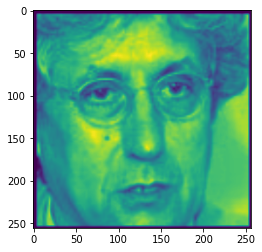

In [ ]:
plt.imshow(image_array_list[11])

In [ ]:
# np.array(image_array_list).shape

In [ ]:
# Creating Training and Test set
from sklearn.model_selection import train_test_split

X = np.array(image_array_list)
Y = image_data.user_id.values 

# x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

# Creating test data (one images from all the classes)
numClasses = len(np.unique(Y))
labels = image_data.user_id
idx_test = [np.where(labels == i)[0][0] for i in range(1, numClasses+1)]  
print("Size of test data: ", len(idx_test))
y_test = Y[idx_test]
x_test = X[idx_test]
x_test = x_test/255.0
print("Test Data: ", (x_test.shape, y_test.shape))

# Creating train data
idx_train = [i for i in range(len(Y)) if i not in idx_test]
print("\nSize of train data: ", len(idx_train))
y_train = Y[idx_train]
x_train = X[idx_train]
x_train = x_train/255.0
print("Train Data: ", (x_train.shape, y_train.shape))



Size of test data:  50
Test Data:  ((50, 256, 256), (50,))

Size of train data:  156
Train Data:  ((156, 256, 256), (156,))


In [ ]:
# from utils import make_pairs 

In [ ]:
# build the positive and negative image pairs
# from utils import make_pairs 

print("Preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(x_train, y_train)
(pairTest, labelTest) = make_pairs(x_test, y_test)

print("Size of Train Data: "+str(pairTrain.shape))
print("Size of Test Data: "+str(pairTest.shape))

Preparing positive and negative pairs...
Size of Train Data: (312, 2, 256, 256)
Size of Test Data: (100, 2, 256, 256)


The Target is: [0]


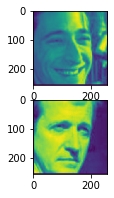

In [ ]:
# Visualizing the image pairs to check if our make_pairs function is working well
sel = np.random.choice(np.arange(0,len(pairTrain)))
imageA = pairTrain[sel][0]
imageB = pairTrain[sel][1]
label = labelTrain[sel]

print("The Target is: "+str(label))
fig, ax = plt.subplots(2,1,figsize=(3, 3))
ax[0].imshow(imageA,interpolation='nearest')
ax[1].imshow(imageB,interpolation='nearest')

The Target is: [1]


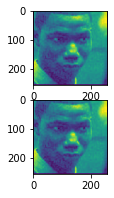

In [ ]:
# Visualizing the image pairs to check if our make_pairs function is working well
sel = np.random.choice(np.arange(0,len(pairTest)))
imageA = pairTest[sel][0]
imageB = pairTest[sel][1]
label = labelTest[sel]

print("The Target is: "+str(label))
fig, ax = plt.subplots(2,1,figsize=(3, 3))
ax[0].imshow(imageA,interpolation='nearest')
ax[1].imshow(imageB,interpolation='nearest')

In [ ]:
# from siamese_network import build_siamese_model

# input_shape = (256,256,1)
# model1 = build_siamese_model(input_shape)

In [ ]:
# model1.summary()

**Siamese Model:**

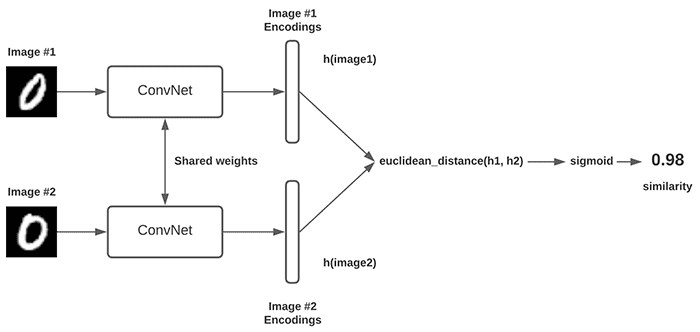

In [ ]:
import tensorflow.keras.backend as K

def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors

	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
        
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
# import the necessary packages (config.py)
import os

# specify the shape of the inputs for our network
IMG_SHAPE = (256, 256, 1)

# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 20

# define the path to the base output directory
BASE_OUTPUT = "output"

# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from siamese_network import euclidean_distance 
from siamese_network import plot_training
import tensorflow.keras.backend as K
import config

In [ ]:
def build_siamese_model(inputShape,embeddingDim=64):
  inputs = Input(inputShape)
  
  x = Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  # x = Dropout(0.3)(x)

  x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  # x = Dropout(0.3)(x)

  x = Conv2D(384, (3, 3), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  # x = Dropout(0.3)(x)

  pooledOutput = GlobalAveragePooling2D()(x)
  pooledOutput = Dense(1024)(pooledOutput)
  outputs = Dense(embeddingDim)(pooledOutput)

  model = Model(inputs,outputs)
  return model

In [ ]:
# configure the siamese network
import config

print("[INFO] building siamese network...")
imgA = Input(shape=config.IMG_SHAPE)
imgB = Input(shape=config.IMG_SHAPE)
featureExtractor = build_siamese_model(config.IMG_SHAPE,embeddingDim=128)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

[INFO] building siamese network...


In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_11 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 128)          2036928     ['input_10[0][0]',               
                                                                  'input_11[0][0]']         

In [ ]:
# print(config.EPOCHS)
# print(config.BATCH_SIZE)

In [ ]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=config.BATCH_SIZE, 
	epochs=20)

[INFO] compiling model...
[INFO] training model...
Epoch 1/20
5/5 [==============================] - 10s 2s/step - loss: 0.6972 - accuracy: 0.6378 - val_loss: 0.5581 - val_accuracy: 1.0000
Epoch 2/20
5/5 [==============================] - 9s 2s/step - loss: 0.6933 - accuracy: 0.6827 - val_loss: 0.6899 - val_accuracy: 0.8200
Epoch 3/20
5/5 [==============================] - 9s 2s/step - loss: 0.6897 - accuracy: 0.6859 - val_loss: 0.6690 - val_accuracy: 0.9800
Epoch 4/20
5/5 [==============================] - 9s 2s/step - loss: 0.6624 - accuracy: 0.6699 - val_loss: 0.5271 - val_accuracy: 1.0000
Epoch 5/20
5/5 [==============================] - 9s 2s/step - loss: 0.6960 - accuracy: 0.6667 - val_loss: 0.6374 - val_accuracy: 1.0000
Epoch 6/20
5/5 [==============================] - 9s 2s/step - loss: 0.6639 - accuracy: 0.6699 - val_loss: 0.6102 - val_accuracy: 1.0000
Epoch 7/20
5/5 [==============================] - 9s 2s/step - loss: 0.6573 - accuracy: 0.6667 - val_loss: 0.5824 - val_accura

[INFO] saving siamese model...


[INFO] plotting training history...


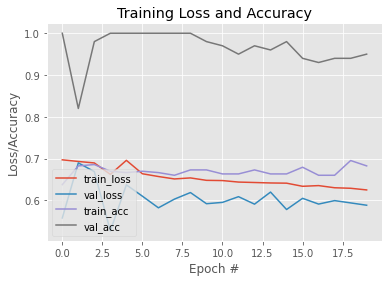

In [ ]:
# serialize the model to disk
print("[INFO] saving siamese model...")
# model.save(config.MODEL_PATH)
model.save('output/siamese_model_live')

# plot the training history
def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)


print("[INFO] plotting training history...")
plot_training(history, config.PLOT_PATH)

## **Testing the Siamese Network:**

In [ ]:
import boto3
import aws_access
s3_client = boto3.client('s3', aws_access_key_id = aws_access.aws_access_key_id, 
                                aws_secret_access_key = aws_access.aws_secret_access_key)


# List objects in the bucket (s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/)
bucket = "hariharan-project-data"
prefix = "Banking-and-Finance/Face-Recognition-KYC-Tool/Data"

fileList = []
for obj in s3_client.list_objects(Bucket=bucket,Prefix=prefix)['Contents']:
    files = obj['Key']
    if ('.jpg' in files) or ('.jpeg' in files) or ('.png' in files):
      fileList.append("s3://hariharan-project-data/"+files)

print("Number of Images: ",len(fileList))

fileList[:10]

Number of Images:  210


['s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg',
 's3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg',
 's3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg',
 's3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg',
 's3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg',
 's3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_4.jpg',
 's3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/11/11_1.jpg',
 's3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/11/11_2.jpg',
 's3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/12/12_1.jpg',
 's3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/12/12_2.jpg']

In [ ]:
import pandas as pd 
pd.set_option('max_colwidth',None)

data = pd.DataFrame(fileList, columns=['s3_img_path'])
print(data.shape)
data.head()

(210, 1)


,s3_img_path
0,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg
1,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg
2,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg
3,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg
4,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg


In [ ]:
data['s3_img_path'][6].split('/')[6]
data['user_id'] = data['s3_img_path'].apply(lambda x: x.split('/')[6]).astype(int)

# EDA
print("Total Unique Users in the data: ", data.user_id.nunique())

median_img_cnt = data.groupby('user_id').count()['s3_img_path'].median()
print("Median number of images per user: ", median_img_cnt)

display(data.head())

Total Unique Users in the data:  52
Median number of images per user:  3.0


,s3_img_path,user_id
0,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_1.jpg,1
1,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/1/1_2.jpg,1
2,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_1.jpg,10
3,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_2.jpg,10
4,s3://hariharan-project-data/Banking-and-Finance/Face-Recognition-KYC-Tool/Data/10/10_3.jpg,10


In [ ]:
image_data = data.copy()

In [ ]:
from PIL import Image
import boto3
from io import BytesIO
import numpy as np
import aws_access

s3_client = boto3.client('s3', aws_access_key_id = aws_access.aws_access_key_id, 
                                aws_secret_access_key = aws_access.aws_secret_access_key)

def view_image_from_s3(bucket, key, region_name='us-east-1'):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    obj = s3_client.get_object(Bucket=bucket, Key = key)
    file_stream = obj['Body']
    im = Image.open(file_stream)
    plt.imshow(im)
    # return np.array(im)

Banking-and-Finance/Face-Recognition-KYC-Tool/Data/52/52_1.jpeg


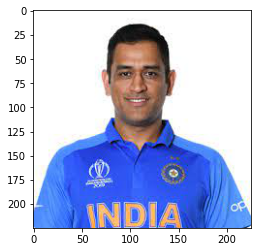

In [ ]:
# Checking the image of the users based on user_id from the azure sql database table 
sel = 52
s3_img_path = image_data[image_data['user_id']==sel]['s3_img_path'].values.tolist()[0]
bucket = 'hariharan-project-data'
key = s3_img_path.split('hariharan-project-data/')[1]
print(key)
img_array = view_image_from_s3(bucket=bucket,key=key)

In [ ]:
# input from user will be one image
# code should take that image and get the probability score for that image with all the other image in our database
# Then return the image (or the details of the image) that has higher probability

In [ ]:
# Getting image in the form of arrays from the filePaths
image_array_list = []

for i in range(len(image_data)):
    s3_img_path = image_data.loc[i,'s3_img_path']
    bucket = 'hariharan-project-data'
    key = s3_img_path.split('data/')[1]
    img_array = read_image_from_s3_with_face(bucket=bucket,key=key)
    image_array_list.append(img_array)

In [ ]:
# bucket = 'hariharan-project-data'
# key = 'Banking-and-Finance/Face-Recognition-KYC-Tool/Data/51/51_2.jpg'
# obj = s3_client.get_object(Bucket=bucket, Key = key)
# file_stream = obj['Body']
# im = Image.open(file_stream) #.convert('L')
# plt.imshow(im)

# gray = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2GRAY)
# plt.imshow(gray)

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# # Detect faces
# faces = face_cascade.detectMultiScale(gray, 1.1, 4)

# # Draw rectangle around the faces and crop the faces
# for (x, y, w, h) in faces:
#     cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 0, 255), 2)
#     faces = gray[y:y + h, x:x + w]
#     faces = cv2.resize(faces, (256,256))
#     # cv2.imshow("face",faces)
#     # plt.imshow(faces)
#     # cv2.imwrite('face.jpg', faces)
  
# plt.imshow(faces)

In [ ]:
len(image_array_list)

210

In [ ]:
# Creating a Scoring set
X = np.array(image_array_list)
Y = image_data.user_id.values 

# x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3)
# print(x_train.shape, x_test.shape)
# print(y_train.shape, y_test.shape)

# Creating test data (one images from all the classes)
labels = image_data.user_id
numClasses = len(np.unique(Y))
idx_test = [np.where(labels == i)[0][0] for i in range(1, numClasses+1)]  
print("Size of scoring data: ", len(idx_test))
y_test = Y[idx_test]
x_test = X[idx_test]
print("Scoring Data: ", (x_test.shape, y_test.shape))

Size of scoring data:  52
Scoring Data:  ((52, 256, 256), (52,))


In [ ]:
# import the necessary packages
import config
import utils
from tensorflow.keras.models import load_model
from imutils.paths import list_images
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [ ]:
print("[INFO] loading test dataset...")
path = "examples"
testImagePaths = list(list_images(path))
testImagePaths

[INFO] loading test dataset...


['examples/35.png',
 'examples/38.png',
 'examples/Parker_35_example.png',
 'examples/10.png',
 'examples/parker_35_2.jpeg',
 'examples/parker_35_3.jpeg',
 'examples/parker_35_4.jpeg',
 'examples/parker_35_5.jpeg',
 'examples/51_2.jpg',
 'examples/52_1.jpeg',
 'examples/52_3.jpeg',
 'examples/52_test.jpeg',
 'examples/51_test.jpg',
 'examples/51_test2.jpg',
 'examples/51_1.jpg']

In [ ]:
# grab the test dataset image paths and then randomly generate a
# total of 10 image pairs
print("[INFO] loading test dataset...")
path = "examples"
testImagePaths = list(list_images(path))
print("Total Number of images in the examples: "+str(len(testImagePaths)))

# np.random.seed(42)
# pairs = np.random.choice(testImagePaths, size=(10, 2))

# load the model from disk
print("[INFO] loading siamese model...")
# model = load_model(config.MODEL_PATH)
model = load_model('output/siamese_model_75_percent_acc')

[INFO] loading test dataset...
Total Number of images in the examples: 15
[INFO] loading siamese model...


In [ ]:
# imageA = cv2.imread(testImagePaths[13])
# type(imageA)
# plt.imshow(np.array(imageA))

examples/52_1.jpeg


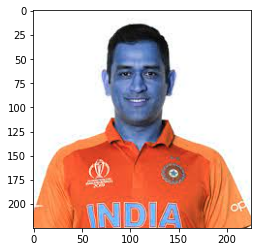

In [ ]:
print(testImagePaths[9])
imageA = cv2.imread(testImagePaths[9])
plt.imshow(imageA)

examples/52_1.jpeg
(256, 256)


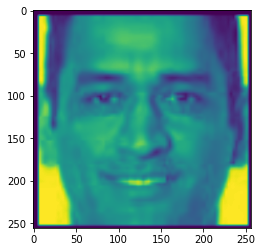

In [ ]:
print(testImagePaths[9])
imageA = cv2.imread(testImagePaths[9])
imageA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
imageA = cv2.resize(imageA,(256,256))
# imageA = imageA/255.0
# imageA.shape
# plt.imshow(imageA)

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  
# Detect faces
faces = face_cascade.detectMultiScale(imageA, 1.1, 4)

# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces:
    cv2.rectangle(imageA, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = imageA[y:y + h, x:x + w]
    faces = cv2.resize(faces, (256,256))

print(np.array(faces).shape)
imageA = np.array(faces)

plt.imshow(imageA)

In [ ]:
  ## Manual One-One image similarity code

# print(testImagePaths[7])
# imageB = cv2.imread(testImagePaths[7])
# imageB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
# imageB = cv2.resize(imageB,(256,256))
# # imageA = imageA/255.0
# # imageA.shape
# # plt.imshow(imageA)

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  
# # Detect faces
# faces = face_cascade.detectMultiScale(imageB, 1.1, 4)

# # Draw rectangle around the faces and crop the faces
# for (x, y, w, h) in faces:
#     cv2.rectangle(imageB, (x, y), (x+w, y+h), (0, 0, 255), 2)
#     faces = imageB[y:y + h, x:x + w]
#     faces = cv2.resize(faces, (256,256))

# print(np.array(faces).shape)
# imageB = np.array(faces)

# plt.imshow(imageB)

In [ ]:
x_test.shape

(52, 256, 256)

In [ ]:
# imageB = imageA.copy()
# plt.imshow(imageB)

In [ ]:
## Manual One-One image similarity code

# # add a batch dimension to both images
# imageA = np.expand_dims(imageA, axis=0)
# imageB = np.expand_dims(imageB, axis=0)
# print(imageA.shape)
# print(imageB.shape)

#   # scale the pixel values to the range of [0, 1]
# imageA = imageA / 255.0
# imageB = imageB / 255.0

# preds = model.predict([imageA, imageB])
# preds

In [ ]:
# for i, imageB in enumerate(x_test[:3]):
#     print(imageB.shape)
#     plt.imshow(imageB)

In [ ]:
prediction_probs = []
# x_test[34]

# imageA = cv2.imread(testImagePaths[0])
# imageA = cv2.resize(imageA,(250,250))
# imageA = imageA/255.0
# imageA.shape

for i, imageB in enumerate(x_test):
	
	if i != 0:
		imageA = origA.copy()
		
    # create a copy of both the images for visualization purpose
	origA = imageA.copy()
	origB = imageB.copy()

	# # add channel a dimension to both the images
	# imageA = np.expand_dims(imageA, axis=-1)
	# imageB = np.expand_dims(imageB, axis=-1)
	
	# add a batch dimension to both images
	imageA = np.expand_dims(imageA, axis=0)
	imageB = np.expand_dims(imageB, axis=0)
	print(imageA.shape)
	print(imageB.shape)

    # scale the pixel values to the range of [0, 1]
	imageA = imageA / 255.0
	imageB = imageB / 255.0

	# use our siamese model to make predictions on the image pair,
	# indicating whether or not the images belong to the same class
	preds = model.predict([imageA, imageB])
	proba = preds[0][0]
	prediction_probs.append(proba)

(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 8s 8s/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 24ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 18ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 20ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 19ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 18ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 17ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 20ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 21ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 19ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 20ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [==============================] - 0s 18ms/step
(1, 256, 256)
(1, 256, 256)
1/1 [=========

In [ ]:
print(prediction_probs)

[0.27026254, 0.21365339, 0.4773057, 0.5182409, 0.52934515, 0.3137518, 0.5302191, 0.40110534, 0.08188051, 0.57482296, 0.4784353, 0.28201517, 0.3331117, 0.39156398, 0.07985458, 0.5013206, 0.43512744, 0.21363737, 0.23047478, 0.43310124, 0.51625305, 0.11986408, 0.17935613, 0.308409, 0.29823607, 0.54472065, 0.17077093, 0.35786355, 0.40670303, 0.2674359, 0.29492334, 0.42944357, 0.3829459, 0.39413854, 0.45191905, 0.57555246, 0.10015158, 0.5887693, 0.16888374, 0.3489191, 0.08440269, 0.060710613, 0.31854463, 0.5273115, 0.41889036, 0.5907497, 0.15394829, 0.4496059, 0.17957507, 0.5761178, 0.3447869, 0.59750515]


In [ ]:
# print(prediction_probs)

In [ ]:
# print(prediction_probs)

In [ ]:
print(len(prediction_probs))     
print(np.argmax(prediction_probs))

y_test[np.argmax(prediction_probs)]

52
51


52

In [ ]:
y_test

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

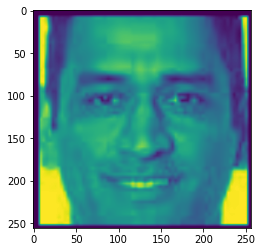

In [ ]:
plt.imshow(x_test[51])

Banking-and-Finance/Face-Recognition-KYC-Tool/Data/52/52_1.jpeg


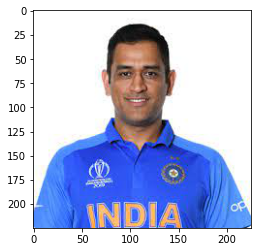

In [ ]:
# Checking the image of the users based on user_id from the azure sql database table 
sel = 52
s3_img_path = image_data[image_data['user_id']==sel]['s3_img_path'].values.tolist()[0]
bucket = 'hariharan-project-data'
key = s3_img_path.split('hariharan-project-data/')[1]
print(key)
img_array = view_image_from_s3(bucket=bucket,key=key)

## **Detecting Faces from the images using Haar Cascasde:**

Image Treatment before modeling:


1.   Converting the images to Greyscale
2.   Cropping only the face from the image



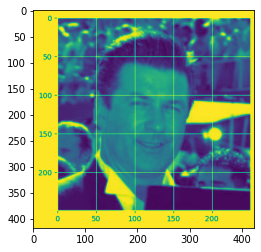

In [ ]:
import cv2
import matplotlib.pyplot as plt
  
# Read the input image
img = cv2.imread('examples/35.png')
  
# Convert into grayscale
gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray1)
  

In [ ]:
# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  
# Detect faces
faces = face_cascade.detectMultiScale(gray1, 1.1, 4)

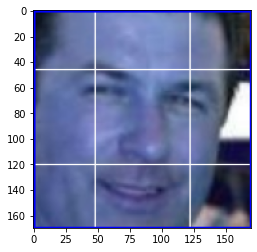

In [ ]:
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    # plt.imshow(faces)
    # cv2.imshow("face",faces)
    cv2.imwrite('face.jpg', faces)
      
# Display the output
plt.imshow(faces)
# cv2.imwrite('detcted.jpg', img)
# cv2.imshow('img', img)
# cv2.waitKey()

In [ ]:
# detected = cv2.imread('detcted.jpg')
# plt.imshow(detected)

In [ ]:
face = cv2.imread('face.jpg')
plt.imshow(face)

In [ ]:
# # Checking the image of the users based on user_id from the azure sql database table 
# sel = 50
# s3_img_path = image_data[image_data['user_id']==sel]['s3_img_path'].values.tolist()[0]
# bucket = 'hariharan-project-data'
# key = s3_img_path.split('hariharan-project-data/')[1]
# print(key)
# img_array = read_image_from_s3_with_face(bucket=bucket,key=key)